In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import sys
sys.path.append("../")

import mitsuba as mi
import drjit as dr
from matplotlib import pyplot as plt
import numpy as np
from helpers.polarization_helpers import *

print(mi.variants())
mi.set_variant("cuda_ad_spectral_polarized")

['scalar_rgb', 'scalar_spectral', 'scalar_spectral_polarized', 'llvm_ad_rgb', 'llvm_ad_mono', 'llvm_ad_mono_polarized', 'llvm_ad_spectral', 'llvm_ad_spectral_polarized', 'cuda_ad_rgb', 'cuda_ad_mono', 'cuda_ad_mono_polarized', 'cuda_ad_spectral', 'cuda_ad_spectral_polarized']


In [2]:
scene = mi.load_file("../scenes/marcus_light_sphere.xml")

In [3]:
def spherical_to_cartesian(radius, theta, phi):
	x = radius * np.sin(theta) * np.sin(phi)
	y = radius * np.cos(theta)
	z = radius * np.sin(theta) * np.cos(phi)

	return np.array([x, y, z])

In [12]:
def render_from_angle(scene, radius, theta, phi, polarized=True, spp=512):
	cam_pos = spherical_to_cartesian(radius, theta, phi)
	polarizer_pos = spherical_to_cartesian(radius - 0.1, theta, phi)

	params = mi.traverse(scene)
	params["polarizer_cam.bsdf.theta.value"] = 0 # Make sure the theta of the polarizer is 0 (might have been altered by previous executions)
	params["sensor.to_world"] = mi.ScalarTransform4f().look_at(origin=cam_pos, target=[0, 0, 0], up=[0, 1, 0])
	params["polarizer_cam.to_world"] = mi.ScalarTransform4f().look_at(origin=polarizer_pos, target=[0, 0, 0], up=[0, 1, 0]).rotate(axis=[0, 0, 1], angle=90)
	params.update()

	if polarized:
		img_0 = mi.render(scene, spp=spp)

		params["polarizer_cam.bsdf.theta.value"] = 90
		params.update()

		img_90 = mi.render(scene, spp=spp)

		return (img_0, img_90)
	else:
		return mi.render(scene, spp=spp)

In [7]:
def render_from_angles(scene, radius, thetas, phis, polarized=True, spp=512):
	return [render_from_angle(scene, radius, theta, phi, polarized, spp) for theta, phi in zip(thetas, phis)]

/tmp/ipykernel_668366/2817523026.py:18: RuntimeWarning: invalid value encountered in power
  plt.imshow(indirect ** (1.0 / 2.2))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1855783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1841444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1837575].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1843961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1868662].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1793253].
Clipping input data to the valid range for 

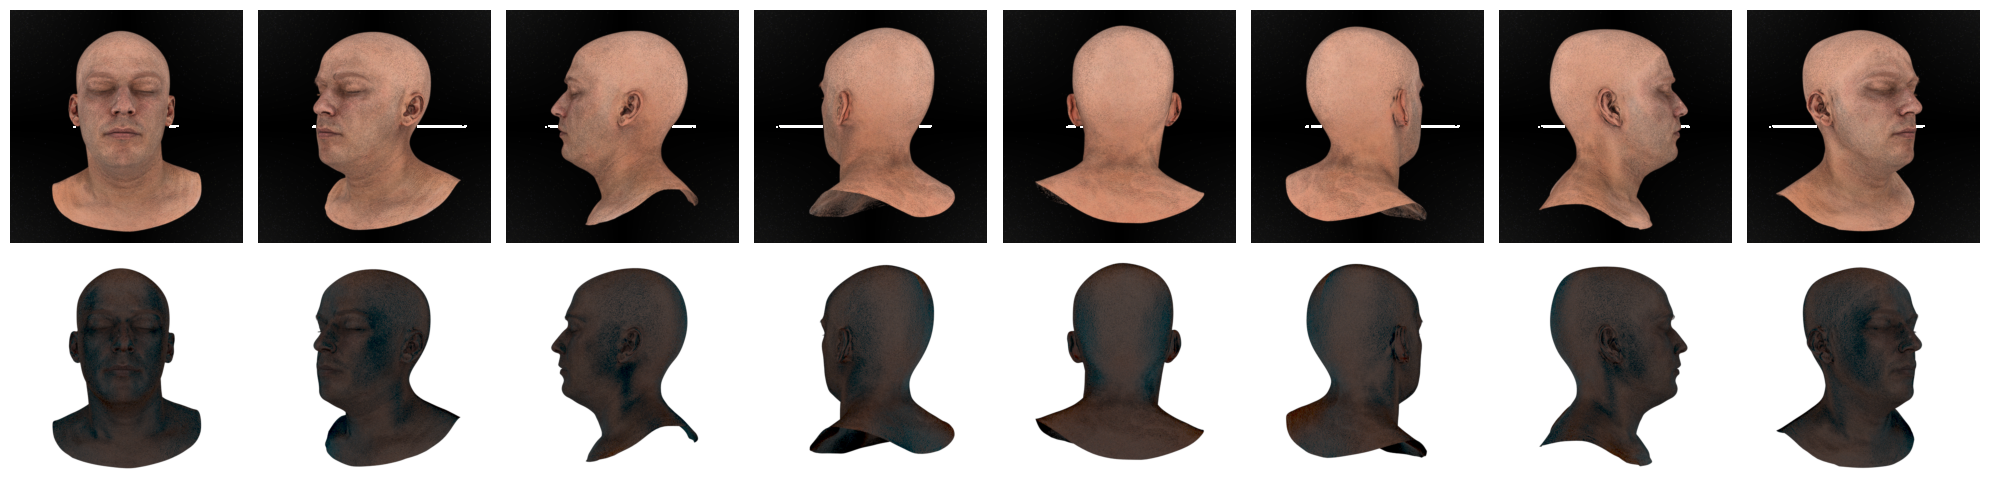

In [17]:
num_images = 8

phis = np.linspace(0, 2*np.pi, num_images, endpoint=False)
thetas = np.full_like(phis, 0.5*np.pi)
radius = 4

images = render_from_angles(scene, radius, thetas, phis, polarized=True)

plt.figure(figsize=(20, 5))

for i, res in enumerate(images):
	img_0, img_90 = res

	indirect, direct = separate(img_0, img_90)

	plt.subplot(2, num_images, i+1)
	plt.axis("off")
	plt.imshow(indirect ** (1.0 / 2.2))
	
	plt.subplot(2, num_images, i+9)
	plt.axis("off")
	plt.imshow(direct ** (1.0 / 2.2))

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00222734..1.0697341].


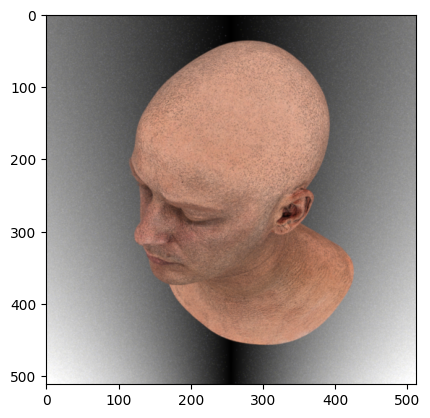

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1726607].


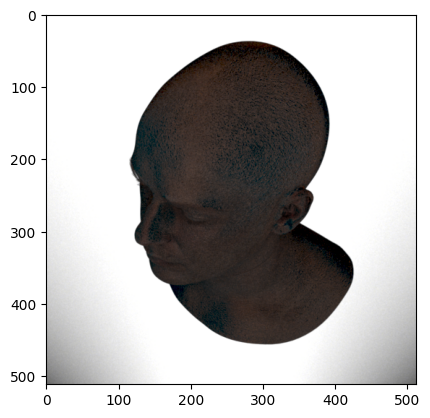

In [5]:
img_0, img_90 = render_from_angle(scene, 4, 0.25*np.pi, 0.25*np.pi)

indirect, direct = separate(img_0, img_90)

plt.imshow(indirect ** (1.0 / 2.2))
plt.show()

plt.imshow(direct ** (1.0 / 2.2))
plt.show()

In [6]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  -------------------------------------------------------------------------------------------------------------------
  Name                                                            Flags    Type              Parent
  -------------------------------------------------------------------------------------------------------------------
  sensor.near_clip                                                         float             PerspectiveCamera
  sensor.far_clip                                                          float             PerspectiveCamera
  sensor.shutter_open                                                      float             PerspectiveCamera
  sensor.shutter_open_time                                                 float             PerspectiveCamera
  sensor.film.size                                                         ScalarVector2u    HDRFilm
  sensor.film.crop_size                                                    ScalarVector2u    HDRFilm
 